In [1]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

In [3]:
import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

In [5]:
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )


tf.__version__: 2.13.0
keras.__version__: 2.13.1


In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [7]:
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [8]:
# import images
!cd /content
data_dir = '/content/drive/My Drive/ads/dataset/'
file_list = os.listdir(data_dir)
angle_01 = []
angle_02 = []
angle_03 = []
pattern = "*.jpg"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
      angle = int(filename[-8:-4])
      if (angle == 1): angle_01.append(os.path.join(data_dir, filename))
      if (angle == 2): angle_02.append(os.path.join(data_dir, filename))
      if (angle == 3): angle_03.append(os.path.join(data_dir, filename))

In [9]:
train_list = [x for x in angle_01]
train_list.extend([x for x in angle_02])
train_list.extend([x for x in angle_03])
df_train = pd.DataFrame(np.concatenate([
                       ['1']*len(angle_01),
                       ['2']*len(angle_02),
                       ['3']*len(angle_03)]),
                        columns = ['label'])
df_train['image'] = [x for x in train_list]
df_train

,label,image
0,1,/content/drive/My Drive/ads/dataset/frame03_1008_0001.jpg
1,1,/content/drive/My Drive/ads/dataset/frame03_0543_0001.jpg
2,1,/content/drive/My Drive/ads/dataset/frame03_0570_0001.jpg
3,1,/content/drive/My Drive/ads/dataset/frame03_0634_0001.jpg
4,1,/content/drive/My Drive/ads/dataset/frame03_0605_0001.jpg
...,...,...
2374,3,/content/drive/My Drive/ads/dataset/frame01_0505_0003.jpg
2375,3,/content/drive/My Drive/ads/dataset/frame01_0397_0003.jpg
2376,3,/content/drive/My Drive/ads/dataset/frame01_0511_0003.jpg
2377,3,/content/drive/My Drive/ads/dataset/frame01_0455_0003.jpg


In [12]:
path = '/content/drive/MyDrive/ads/dataset'

data_img = []
img_list = list(df_train['image'])


for each in img_list:
    each_path = os.path.join(path, each)
    image = cv2.imread(each_path)

    height, _, _ = image.shape
    image = image[int(height/5):, :, :]

    image = cv2.GaussianBlur(image, (3,3), 0)

    image = cv2.resize(image, (200, 66))
    image = image / 255
    data_img.append(image)

X = np.array(data_img)

In [13]:
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))
y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=int8)

In [14]:
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

Shape of X:  (2379, 66, 200, 3)
Shape of y:  (2379, 3)


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_valid.shape)
print('y_val shape  : ', y_valid.shape)

Training data: 1903
Validation data: 476
X_train shape:  (1903, 66, 200, 3)
y_train shape:  (1903, 3)
X_val shape  :  (476, 66, 200, 3)
y_val shape  :  (476, 3)


In [40]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')

    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 dropout_6 (Dropout)         (None, 3, 20, 64)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

In [41]:
from tensorflow.keras.models import model_from_json
model_output_dir = '/content/drive/My Drive/ads/model/'

model_json = model.to_json()

with open(os.path.join(model_output_dir, 'model_architecture.json'), 'w') as json_file:
    json_file.write(model_json)

In [42]:
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

model_output_dir = '/content/drive/My Drive/ads/model/'
saved_model_path = os.path.join(model_output_dir, 'lane_navigation_check.h5')
epochs = 35
batch_size = 32

ch_pt = callbacks.ModelCheckpoint(filepath=saved_model_path ,monitor='val_loss',save_best_only=True,save_weights_only=True)
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
rd_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

if os.path.exists(saved_model_path):
    model = load_model(saved_model_path)
    initial_epoch = model.optimizer.iterations.numpy() // epochs
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_valid, y_valid), callbacks=[ch_pt,rd_lr,es_cb])


model.save(os.path.join(model_output_dir, 'lane_navigation_final.h5'))

Epoch 1/35
60/60 [==============================] - 3s 17ms/step - loss: 1.2973 - accuracy: 0.3216 - val_loss: 1.0928 - val_accuracy: 0.3761 - lr: 0.0010
Epoch 2/35
60/60 [==============================] - 1s 9ms/step - loss: 1.2773 - accuracy: 0.3789 - val_loss: 1.1158 - val_accuracy: 0.3319 - lr: 0.0010
Epoch 3/35
60/60 [==============================] - 1s 10ms/step - loss: 1.0015 - accuracy: 0.5171 - val_loss: 0.5952 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 4/35
60/60 [==============================] - 1s 10ms/step - loss: 0.5323 - accuracy: 0.8014 - val_loss: 0.5443 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 5/35
60/60 [==============================] - 1s 10ms/step - loss: 0.4418 - accuracy: 0.8308 - val_loss: 0.4730 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 6/35
60/60 [==============================] - 1s 10ms/step - loss: 0.3838 - accuracy: 0.8476 - val_loss: 0.4120 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 7/35
60/60 [==============================] - 1s 10ms/step - loss: 0.34

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


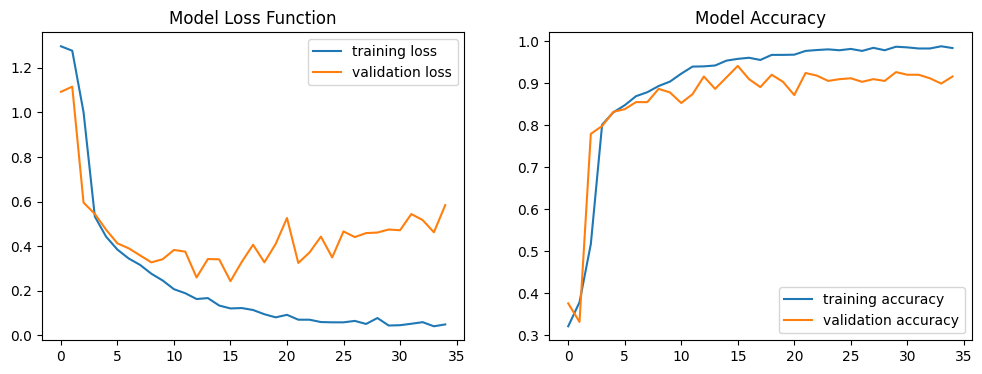

In [43]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

In [45]:
model = load_model('/content/drive/MyDrive/ads/model/lane_navigation_final.h5')
test_dir = '/content/drive/MyDrive/ads/test-dataset/'
file_list = os.listdir(test_dir)

def preprocess_image(image):
    height, _, _ = image.shape
    image = image[int(height/5):,:,:]

    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200, 66))
    image = image / 255
    return image

num = len(file_list)
correct_cnt = 0
for filename in file_list:
  image = cv2.imread(os.path.join(test_dir, filename))
  image = preprocess_image(image)
  X = np.asarray([image])
  probability = model.predict(X, verbose=0)[0]
  answer = int(filename[-8:-4])
  direction = np.argmax(probability) + 1
  print(f'answer: {answer} predict: {direction}')
  if answer == direction: correct_cnt += 1

print(f'correct rate: {correct_cnt / num * 100}%')


answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 predict: 2
answer: 2 pre